In [1]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from diff_predictor import core, data_process, predxgboost, spatial



from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import xgboost as xgb
# from xgboost import cv

import shap

Using current directory for loading/saving: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/notebooks
To change current directory, call change_dir(...)


In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/notebooks
Using current directory for loading data: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor


In [3]:
dataset_path = workbookDir + '/data/age_feature_data/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]

In [4]:
fstats_tot = data_process.generate_fullstats(dataset_path, filelist, ['P14', 'NT', 'P70'], 'age')

P14
NT
Adding file features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
P70
P14
NT
Adding file features_NT_brain_2_slice_3_vid_3.csv size: (817, 9

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



P14
NT
P70
Adding file features_P70_40nm_s1_v2.csv size: (12, 67)
P14
NT
P70
Adding file features_P70_40nm_s1_v3.csv size: (25, 67)
P14
NT
P70
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
P14
NT
P70
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
P14
NT
P70
Adding file features_P70_40nm_s2_v1.csv size: (148, 67)
P14
NT
P70
Adding file features_P70_40nm_s2_v2.csv size: (148, 67)
P14
NT
P70
Adding file features_P70_40nm_s2_v3.csv size: (240, 67)
P14
NT
P70
Adding file features_P70_40nm_s2_v4.csv size: (308, 67)
P14
NT
P70
Adding file features_P70_40nm_s2_v5.csv size: (186, 67)
P14
NT
P70
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
P14
NT
P70
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
P14
NT
P70
Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
P14
NT
P70
Adding file features_P70_40nm_s3_v4.csv size: (2909, 67)
P14
NT
P70
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)


In [5]:
ecm = fstats_tot[columns]

NameError: name 'columns' is not defined

In [ ]:
drop_one = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
drop_one.shape

In [ ]:
drop_two = ecm[columns].dropna()
drop_two.shape

In [ ]:
drop_two[columns].isnull().sum()/len(drop_two)

In [ ]:
ecm.columns

In [7]:
# The column Deff2 currently has a super high number (~97%) of null values, so might be worth not including
# As such, it is commented out below
columns = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    #'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
 #   'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha',
    'Mean D_fit',
    'Mean kurtosis',
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3',
    'Mean AR',
    'Mean elongation',
    'Mean boundedness',
    'Mean fractal_dim',
    'Mean trappedness',
    'Mean efficiency',
    'Mean straightness',
    'Mean MSD_ratio',
    'Mean Deff1',
    #'Mean Deff2',
    'X',
    'Y',
    'age'
]

target = 'age'

In [8]:
ecm = fstats_tot[columns]
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] # removes rows with nan or inf points

#ecm = ecm.dropna()
ecm.shape

(33737, 33)

In [9]:
bal_ecm = data_process.balance_data(ecm, target)
#print(ecm[columns].isnull().sum()/len(ecm))


Ratio before data balance (NT:P14:P70) = 14869:4900:13968
Ratio after balance (NT:P14:P70) = 4900:4900:4900


In [10]:
#bal_ecm[target].unique()

In [105]:
sampled_df = pd.DataFrame()

for targ in ecm[target].unique():
    print(targ)
    df = ecm[ecm[target] == targ]
    #print(df[columns].isnull().sum()/len(df))
    #print()
    df_sample = df.sample(n=4900)
    sampled_df = sampled_df.append(df_sample)

NT
P14
P70


In [106]:
sampled_df.head()

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean boundedness,Mean fractal_dim,Mean trappedness,Mean efficiency,Mean straightness,Mean MSD_ratio,Mean Deff1,X,Y,age
1233,0.571872,9.834329,5.351905,0.966667,0.092060,0.424058,2.466185,0.594515,0.148215,1.320931,...,0.085145,1.494433,-0.201399,1.080750,0.287314,0.471546,10.206598,1865.175795,30.190092,NT
15676,0.806278,29.096859,2.625432,0.949031,0.114358,0.379532,2.218997,0.549346,0.094981,1.459170,...,0.079183,1.845562,-0.203134,0.541023,0.188319,0.072936,9.650161,1645.407380,1088.687838,NT
6037,1.404499,9.469751,1.443783,0.984354,0.062789,0.492367,3.867500,0.741435,0.062771,1.341979,...,0.087333,1.642152,-0.200793,0.798416,0.215354,0.352881,13.974769,1735.908239,222.136793,NT
2153,0.014890,10.610102,2.000126,0.185975,0.630383,0.026034,1.266365,0.210338,0.312135,3.631558,...,0.200358,2.181343,-0.167313,0.279319,0.165869,0.858961,7.567605,1138.027058,460.341405,NT
184,1.138077,9.572181,1.764481,0.476868,0.427835,0.083696,1.110909,0.099836,0.149647,1.815442,...,0.063294,1.746935,-0.208009,0.916011,0.214108,0.048864,10.036256,1723.521731,1963.372590,NT


In [107]:
sampled_df = data_process.bin_data(sampled_df)

In [108]:
sampled_df.columns

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Mean alpha',
       'Mean D_fit', 'Mean kurtosis', 'Mean asymmetry1', 'Mean asymmetry2',
       'Mean asymmetry3', 'Mean AR', 'Mean elongation', 'Mean boundedness',
       'Mean fractal_dim', 'Mean trappedness', 'Mean efficiency',
       'Mean straightness', 'Mean MSD_ratio', 'Mean Deff1', 'X', 'Y', 'age',
       'binx', 'biny', 'bins'],
      dtype='object')

In [109]:
label_df = sampled_df['age']
features_df = sampled_df.drop(['age', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)

In [110]:
features = features_df.columns

In [111]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [112]:
print(le.classes_)

['NT' 'P14' 'P70']


In [113]:
sampled_df[['encoded_target', target]][100:110]

,encoded_target,age
12664,0,NT
3592,0,NT
6124,0,NT
3081,0,NT
2849,0,NT
6161,0,NT
5508,0,NT
9097,0,NT
11338,0,NT
13703,0,NT


In [114]:
#Check lengths of datasets:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(sampled_df):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(sampled_df):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(sampled_df):.3f}%)')
    except:
        pass
get_lengths(sampled_df, X_train, X_test, X_val)

Tot before split: 14700
Training: 7422 (0.505%)
Testing: 3639 (0.248%)
Evaluation: 3639 (0.248%)


In [115]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
         # GPU integration will cut time in ~half:
         'gpu_id' : 0,
         'tree_method': 'gpu_hist',
         'predictor': 'gpu_predictor'
         }

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import operator

In [117]:
features

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Mean alpha',
       'Mean D_fit', 'Mean kurtosis', 'Mean asymmetry1', 'Mean asymmetry2',
       'Mean asymmetry3', 'Mean AR', 'Mean elongation', 'Mean boundedness',
       'Mean fractal_dim', 'Mean trappedness', 'Mean efficiency',
       'Mean straightness', 'Mean MSD_ratio', 'Mean Deff1'],
      dtype='object')

In [118]:
(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(X_train, y_train, features, init_params=param, nfold=5, num_boost_round=2000, early_stopping_rounds=3, use_gpu='True')

Using CV with subsample={0.6}, colsample_bytree={1.0}
New best param found: mlogloss = {0.4090058846672056}, boost_rounds = {1678}
Using CV with subsample={1.0}, colsample_bytree={0.9}
Using CV with subsample={0.6}, colsample_bytree={0.5}
Using CV with subsample={0.6}, colsample_bytree={0.9}
New best param found: mlogloss = {0.4083349664510913}, boost_rounds = {1768}
Using CV with subsample={1.0}, colsample_bytree={0.5}
Using CV with subsample={1.0}, colsample_bytree={1.0}
Using CV with max_depth={3}, min_child_weight={2}
New best param found: mlogloss = {0.4083828412826732}, boost_rounds = {1768}
Using CV with max_depth={5}, min_child_weight={10}
New best param found: mlogloss = {0.40580473928860145}, boost_rounds = {1577}
Using CV with max_depth={10}, min_child_weight={10}
Using CV with max_depth={3}, min_child_weight={0}
Using CV with max_depth={3}, min_child_weight={10}
Using CV with max_depth={2}, min_child_weight={10}
Using CV with max_depth={2}, min_child_weight={0}
Using CV wit

Using CV with max_depth={3}, min_child_weight={0}
Using CV with max_depth={3}, min_child_weight={10}
Using CV with max_depth={2}, min_child_weight={10}
Using CV with max_depth={2}, min_child_weight={0}
Using CV with max_depth={5}, min_child_weight={0}
Using CV with max_depth={2}, min_child_weight={2}
Using CV with max_depth={10}, min_child_weight={0}
Using CV with max_depth={5}, min_child_weight={2}
New best param found: mlogloss = {0.39391873201293454}, boost_rounds = {653}
Using CV with max_depth={10}, min_child_weight={2}
Using CV with eta={0.01}, gamma={0.2}
New best param found: mlogloss = {0.3951369401778496}, boost_rounds = {607}
Using CV with eta={0.01}, gamma={1.0}
New best param found: mlogloss = {0.39457220102398277}, boost_rounds = {607}
Using CV with eta={0.01}, gamma={0.5}
New best param found: mlogloss = {0.39433622608461333}, boost_rounds = {607}
Using CV with eta={0.01}, gamma={0}
New best param found: mlogloss = {0.39391873201293454}, boost_rounds = {653}
Using CV wit

In [119]:
best_boost_rounds

(     train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
 0               1.088672        3.508764e-08            1.089810   
 1               1.078862        1.108628e-07            1.081254   
 2               1.069446        2.221445e-07            1.072923   
 3               1.060024        3.523018e-07            1.064613   
 4               1.050644        4.709593e-07            1.056375   
 ..                   ...                 ...                 ...   
 649             0.142973        4.586244e-05            0.394066   
 650             0.142773        4.582403e-05            0.394035   
 651             0.142576        4.566049e-05            0.393982   
 652             0.142380        4.528965e-05            0.393937   
 653             0.142190        4.505554e-05            0.393919   
 
      test-mlogloss-std  
 0         3.564267e-08  
 1         1.405823e-07  
 2         1.816196e-07  
 3         3.119073e-07  
 4         5.486975e-07  
 ..           

In [120]:
def train(param, dtrain, dtest, dval=None, evals=[(dtrain, 'train')], num_round=40):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals, )
    true_label = dtest.get_label()
    ypred = model.predict(dtest)
    preds = [np.where(x == np.max(x))[0][0] for x in ypred]
    acc = metrics.accuracy_score(true_label, preds)
    print("Accuracy:",acc)
    return model, acc, true_label, preds
booster, acc, true_label, preds = train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=653)


[0]	train-mlogloss:1.09455	eval-mlogloss:1.09456
[1]	train-mlogloss:1.09045	eval-mlogloss:1.09058
[2]	train-mlogloss:1.08647	eval-mlogloss:1.08678
[3]	train-mlogloss:1.08262	eval-mlogloss:1.08296
[4]	train-mlogloss:1.07876	eval-mlogloss:1.07920
[5]	train-mlogloss:1.07487	eval-mlogloss:1.07540
[6]	train-mlogloss:1.07120	eval-mlogloss:1.07170
[7]	train-mlogloss:1.06749	eval-mlogloss:1.06802
[8]	train-mlogloss:1.06393	eval-mlogloss:1.06451
[9]	train-mlogloss:1.06026	eval-mlogloss:1.06086
[10]	train-mlogloss:1.05656	eval-mlogloss:1.05728
[11]	train-mlogloss:1.05292	eval-mlogloss:1.05376
[12]	train-mlogloss:1.04925	eval-mlogloss:1.05016
[13]	train-mlogloss:1.04582	eval-mlogloss:1.04680
[14]	train-mlogloss:1.04229	eval-mlogloss:1.04328
[15]	train-mlogloss:1.03876	eval-mlogloss:1.03972
[16]	train-mlogloss:1.03532	eval-mlogloss:1.03634
[17]	train-mlogloss:1.03167	eval-mlogloss:1.03274
[18]	train-mlogloss:1.02811	eval-mlogloss:1.02930
[19]	train-mlogloss:1.02467	eval-mlogloss:1.02586
[20]	train

[163]	train-mlogloss:0.70190	eval-mlogloss:0.71149
[164]	train-mlogloss:0.70049	eval-mlogloss:0.71015
[165]	train-mlogloss:0.69909	eval-mlogloss:0.70881
[166]	train-mlogloss:0.69771	eval-mlogloss:0.70748
[167]	train-mlogloss:0.69634	eval-mlogloss:0.70617
[168]	train-mlogloss:0.69497	eval-mlogloss:0.70489
[169]	train-mlogloss:0.69355	eval-mlogloss:0.70359
[170]	train-mlogloss:0.69216	eval-mlogloss:0.70225
[171]	train-mlogloss:0.69089	eval-mlogloss:0.70098
[172]	train-mlogloss:0.68948	eval-mlogloss:0.69968
[173]	train-mlogloss:0.68800	eval-mlogloss:0.69823
[174]	train-mlogloss:0.68655	eval-mlogloss:0.69685
[175]	train-mlogloss:0.68520	eval-mlogloss:0.69554
[176]	train-mlogloss:0.68381	eval-mlogloss:0.69431
[177]	train-mlogloss:0.68250	eval-mlogloss:0.69306
[178]	train-mlogloss:0.68103	eval-mlogloss:0.69168
[179]	train-mlogloss:0.67977	eval-mlogloss:0.69046
[180]	train-mlogloss:0.67846	eval-mlogloss:0.68920
[181]	train-mlogloss:0.67709	eval-mlogloss:0.68790
[182]	train-mlogloss:0.67579	ev

[324]	train-mlogloss:0.54226	eval-mlogloss:0.56002
[325]	train-mlogloss:0.54153	eval-mlogloss:0.55937
[326]	train-mlogloss:0.54084	eval-mlogloss:0.55872
[327]	train-mlogloss:0.54015	eval-mlogloss:0.55807
[328]	train-mlogloss:0.53955	eval-mlogloss:0.55749
[329]	train-mlogloss:0.53894	eval-mlogloss:0.55692
[330]	train-mlogloss:0.53829	eval-mlogloss:0.55634
[331]	train-mlogloss:0.53768	eval-mlogloss:0.55577
[332]	train-mlogloss:0.53696	eval-mlogloss:0.55512
[333]	train-mlogloss:0.53627	eval-mlogloss:0.55451
[334]	train-mlogloss:0.53569	eval-mlogloss:0.55397
[335]	train-mlogloss:0.53516	eval-mlogloss:0.55347
[336]	train-mlogloss:0.53453	eval-mlogloss:0.55295
[337]	train-mlogloss:0.53392	eval-mlogloss:0.55231
[338]	train-mlogloss:0.53333	eval-mlogloss:0.55175
[339]	train-mlogloss:0.53271	eval-mlogloss:0.55124
[340]	train-mlogloss:0.53207	eval-mlogloss:0.55064
[341]	train-mlogloss:0.53142	eval-mlogloss:0.55003
[342]	train-mlogloss:0.53083	eval-mlogloss:0.54948
[343]	train-mlogloss:0.53021	ev

[485]	train-mlogloss:0.46533	eval-mlogloss:0.48885
[486]	train-mlogloss:0.46505	eval-mlogloss:0.48861
[487]	train-mlogloss:0.46474	eval-mlogloss:0.48835
[488]	train-mlogloss:0.46436	eval-mlogloss:0.48804
[489]	train-mlogloss:0.46407	eval-mlogloss:0.48774
[490]	train-mlogloss:0.46383	eval-mlogloss:0.48754
[491]	train-mlogloss:0.46352	eval-mlogloss:0.48726
[492]	train-mlogloss:0.46318	eval-mlogloss:0.48694
[493]	train-mlogloss:0.46286	eval-mlogloss:0.48665
[494]	train-mlogloss:0.46252	eval-mlogloss:0.48636
[495]	train-mlogloss:0.46219	eval-mlogloss:0.48606
[496]	train-mlogloss:0.46192	eval-mlogloss:0.48583
[497]	train-mlogloss:0.46155	eval-mlogloss:0.48546
[498]	train-mlogloss:0.46122	eval-mlogloss:0.48520
[499]	train-mlogloss:0.46093	eval-mlogloss:0.48494
[500]	train-mlogloss:0.46067	eval-mlogloss:0.48472
[501]	train-mlogloss:0.46036	eval-mlogloss:0.48442
[502]	train-mlogloss:0.46007	eval-mlogloss:0.48411
[503]	train-mlogloss:0.45977	eval-mlogloss:0.48383
[504]	train-mlogloss:0.45939	ev

[646]	train-mlogloss:0.42515	eval-mlogloss:0.45421
[647]	train-mlogloss:0.42496	eval-mlogloss:0.45408
[648]	train-mlogloss:0.42477	eval-mlogloss:0.45395
[649]	train-mlogloss:0.42454	eval-mlogloss:0.45377
[650]	train-mlogloss:0.42438	eval-mlogloss:0.45361
[651]	train-mlogloss:0.42416	eval-mlogloss:0.45345
[652]	train-mlogloss:0.42393	eval-mlogloss:0.45326
Accuracy: 0.8304479252541908


In [121]:
class_names = [str(le.classes_[0]), str(le.classes_[1]), str(le.classes_[2])]
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

          NT     0.7727    0.7466    0.7594      1243
         P14     0.8966    0.8638    0.8799      1204
         P70     0.8247    0.8842    0.8534      1192

    accuracy                         0.8304      3639
   macro avg     0.8313    0.8315    0.8309      3639
weighted avg     0.8307    0.8304    0.8301      3639



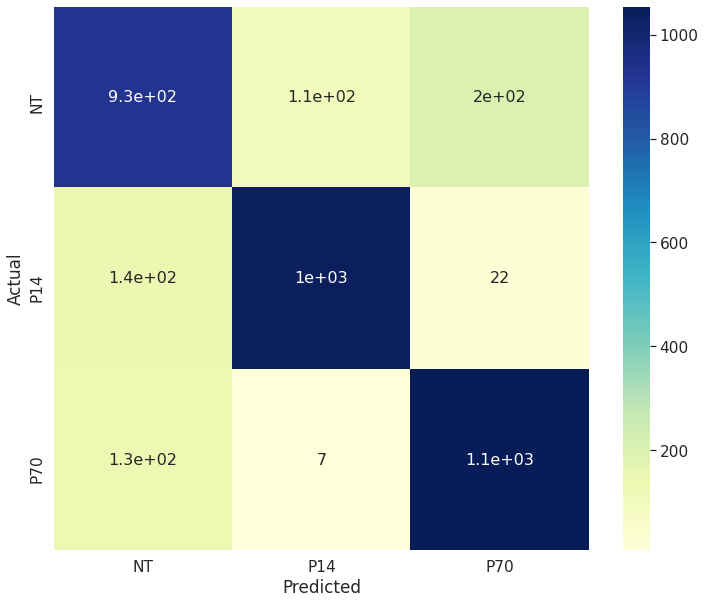

In [122]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [123]:
model_bytearray = booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

booster.save_raw = myfun

In [124]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [125]:
c_14 = '#E69F00'
c_35 = '#56B4E9'
c_70 = '#009E73'

colors = [c_70, c_35, c_14]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

In [126]:
class_inds

array([2, 1, 0])

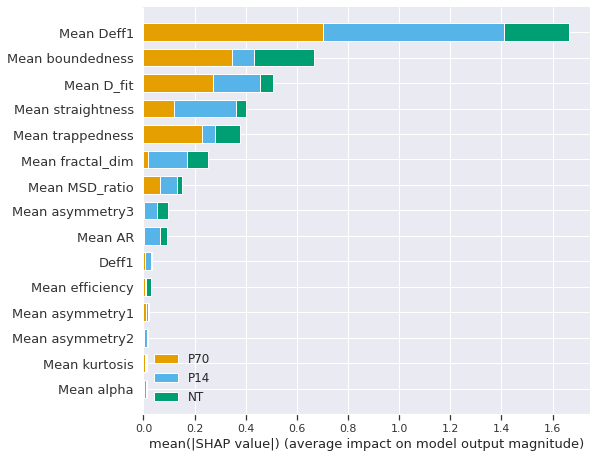

In [127]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)